# IFAT Interface Notebook

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline
BrianLogger.suppress_hierarchy('brian2.codegen.generators.base')

## Define Functions

In [1]:
def calc_weight(M, alpha, mu, sigma):
    alpha = alpha/fF
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * np.around(output/(5.0))
    output[output==0.] = nan
    return output

In [355]:
def write_exc_syn_old(group, file):
    M = shape(group['weights'])
    with open(file,'w') as f:
        for i in range(M[0]):
            f.write('{}:'.format(i+30*34*group['stype']))
            for j in range(M[1]):
                if ~isnan(group['weights'][i,j]):
                    f.write(str(make_event(j, group['ttype'], int(group['weights'][i,j]/5), group['Em'])) + ' ')
            if i<M[0]-1:
                f.write('\n')

def write_inh_syn_old(i2e, i2i, file, append=False):
    M = shape(i2e['weights'])
    open_param  = 'a+' if append else 'w+'
    with open(file,open_param) as f:
        if append:
            f.write('\n')
        for i in range(M[0]):
            f.write('{}:'.format(i+30*34*i2e['stype']))
            for j in range(M[1]):
                if ~isnan(i2e['weights'][i,j]):
                    f.write(str(make_event(j, i2e['ttype'], int(i2e['weights'][i,j]/5), i2e['Em'])) + ' ')
                if ~isnan(i2i['weights'][i,j]):
                    f.write(str(make_event(j, i2i['ttype'], int(i2i['weights'][i,j]/5), i2i['Em'])) + ' ')
            if i<M[0]-1:
                f.write('\n')

In [356]:
def write_exc_syn(group, file, shuffle=False):
    M = shape(group['weights'])
    with open(file,'w') as f:
        for i in range(M[0]):
            f.write('{}:'.format(i+30*34*group['stype']))
            idx_order = permutation(M[0]) if shuffle else range(M[0])
            #shuffle_idx = permutation(M[0])
            for j in idx_order:
                if ~isnan(group['weights'][i,j]):
                    f.write(str(make_event(j, group['ttype'], int(group['weights'][i,j]/5), group['Em'])) + ' ')
            if i<M[0]-1:
                f.write('\n')

def write_inh_syn(i2e, i2i, file, append=False, shuffle=False):
    M = shape(i2e['weights'])
    open_param  = 'a+' if append else 'w+'
    with open(file,open_param) as f:
        if append:
            f.write('\n')
        for i in range(M[0]):
            f.write('{}:'.format(i+30*34*i2e['stype']))
            idx_order = permutation(M[0]) if shuffle else range(M[0])
            #shuffle_idx = permutation(M[0])
            for j in idx_order:
                if ~isnan(i2e['weights'][i,j]):
                    f.write(str(make_event(j, i2e['ttype'], int(i2e['weights'][i,j]/5), i2e['Em'])) + ' ')
                if ~isnan(i2i['weights'][i,j]):
                    f.write(str(make_event(j, i2i['ttype'], int(i2i['weights'][i,j]/5), i2i['Em'])) + ' ')
            if i<M[0]-1:
                f.write('\n')

In [357]:
def make_spgen(timearray, spikes):
    N = sum(spikes)
    times = np.zeros(N)
    indices = np.zeros(N)
    count = 0
    for idx, time in enumerate(timearray):
        for ind in range(shape(spikes)[0]):
            if spikes[ind, idx]:
                times[count] = time/second
                indices[count] = ind
                count += 1
    return times*second, indices

In [358]:
def read_ifat_spikes(file, dt):
    dt = dt/second
    with open(file, 'r') as f:
        linecount = sum(1 for line in f)
    #inds = np.zeros(linecount)
    exc_sp = []
    exc_t  = []
    inh_sp = []
    inh_t  = []
    rollover_cnt = 0
    last_hi = 0
    offset = 0
    MAXLO = (1<<13)
    MAXBOTH = (1<<16)-1
    with open(file,'r') as f:
        for idx, line in enumerate(f):
            [row, col, addrx, count_hi, count_lo] = list(map(int,line.split()))
            if count_hi < last_hi:
                rollover_cnt += 1
                #print(rollover_cnt)
            last_hi = count_hi
            
            neuron = row*30 + col
            
            raw_time = MAXLO*count_hi + count_lo
            if idx == 0:
                offset = raw_time
            time = dt/second * (raw_time - offset + rollover_cnt*MAXBOTH)
            
            if addrx:
                inh_sp.append(neuron)
                inh_t.append(time)
            else:
                exc_sp.append(neuron)
                exc_t.append(time)
    return asarray(exc_sp), asarray(exc_t), asarray(inh_sp), asarray(inh_t)

In [359]:
def read_ifat_spikes_2(file, dt):
    dt = dt/second
    with open(file, 'r') as f:
        linecount = sum(1 for line in f)
    #inds = np.zeros(linecount)
    exc_sp = []
    exc_t  = []
    inh_sp = []
    inh_t  = []
    rollover_cnt = 0
    last_count = 0
    offset = 0
    MAXCOUNT = (1<<16)
    with open(file,'r') as f:
        for idx, line in enumerate(f):
            [row, col, addrx, counter] = list(map(int,line.split()))
            if counter < last_count:
                rollover_cnt += 1
                print(rollover_cnt)
            last_count = counter
            
            neuron = row*30 + col
            
            #raw_time = counter
            if idx == 0:
                offset = counter
            time = dt/second * (counter - offset + rollover_cnt*MAXCOUNT)
            
            if addrx:
                inh_sp.append(neuron)
                inh_t.append(time)
            else:
                exc_sp.append(neuron)
                exc_t.append(time)
    return asarray(exc_sp), asarray(exc_t), asarray(inh_sp), asarray(inh_t)

In [360]:
def make_event(index, addr_x, wm, em_sel, wt=0, chip_sel=1, thr_switch=0, debug=0):
    if(debug):
        print("\tMaking event..\n");

    wm_pos = 0;
    wt_pos = 5;
    row_pos = 10;
    col_pos = 16;
    em_sel_pos = 22;
    chip_sel_pos = 24;
    col_sel_pos = 28;
    addr_x_pos = 29;
    thr_switch_pos = 30;
    num_rows = 34;
    num_cols = 30;
    col_sel = 1;

    row = int(index/num_cols);
    col = int(index%num_cols)
    row_i = (row<<row_pos) & (0b11111<<row_pos);
    col_i = (col<<col_pos) & (0b11111<<col_pos);
    addrx_i = (addr_x<<addr_x_pos) & (0b11111<<addr_x_pos);
    wm_i = (wm<<wm_pos) & (0b11111<<wm_pos);
    wt_i = (wt<<wt_pos) & (0b11111<<wt_pos);
    em_i = (em_sel<<em_sel_pos) & (0b11111<<em_sel_pos);
    cs_i = (chip_sel<<chip_sel_pos) & (0b11111<<chip_sel_pos);
    col_sel_i = (col_sel<<col_sel_pos) & (0b11111<<col_sel_pos);
    thr_sw_i = (thr_switch<<thr_switch_pos) & (0b11111<<thr_switch_pos);

    out_event = row_i | col_i | addrx_i | wm_i | wt_i | em_i | cs_i | col_sel_i | thr_sw_i;
    out_event = out_event & 0xffffffff
    
    if(debug):
        print("\t\tout event:",end=' ')
        print(format(out_event, '032b'))

    return out_event;

In [361]:
def poissonSpikeGen(rate=3.0*kHz, dt=10.0*us, t=1*second, num_neur=1):
    bins = int(t/dt)
    #print(bins)
    output = rand(num_neur, bins) < rate*dt
    time = arange(0,t,dt)
    return time, output

## Begin Simulation

In [362]:
MODE = 'adaptive'
PARASITICS = True

In [363]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [2]:
# IFAT specific definitions
fF = 0.001 * pF
Vdd = 5 * volt
Cm = Ct = 440 * fF
Cl = 2 * fF

W_vals  = np.array([5, 10, 20, 40, 80]) * fF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = True
par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

# Model parameters
Vm_r = 1 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3 * volt
flt  = 0 * MHz
Cst  = 0 * fF

M = 64

# Connectivity specifics
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
mu3 = pi
sigma = 36 * pi/180

NameError: name 'pF' is not defined

In [365]:
bayo_dt = 75*us
bayo_time = 150*ms

Total number of Poisson spikes: 36206


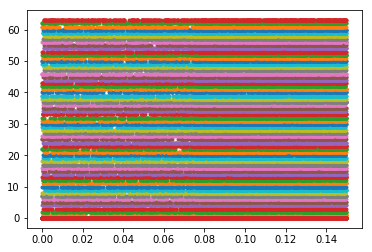

In [387]:
time_1, out_1 = poissonSpikeGen(rate=2.5*kHz, dt=bayo_dt, t=bayo_time/2, num_neur=M)
time_2, out_2 = poissonSpikeGen(rate=5*kHz, dt=bayo_dt, t=bayo_time/2, num_neur=M)
time_2 = time_2/second + bayo_time/(2*second)
time = concatenate((time_1,time_2))*second
out = concatenate((out_1, out_2),axis=1)

for idx in range(M):
    plot(time,out[idx]*idx,'.');

print('Total number of Poisson spikes: {}'.format(sum(out)))

times, indices = make_spgen(time, out)

In [388]:
start_scope()
defaultclock.dt = bayo_dt

G1 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G1.Vt = Vt_r
G1.Vm = Vm_r
G1_exc = G1[:M]
G1_inh = G1[M:]

G1_e2i = Synapses(G1_exc, G1_inh, syn_eq, on_pre=presyn_eq)
W1_e2i = calc_weight(M,alpha,mu1,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_e2i[ii,jj]):
            G1_e2i.connect(i=ii,j=jj)
G1_e2i.Em = Em_vals[3]
G1_e2i.W = W1_e2i[~isnan(W1_e2i)].flatten()*fF

G1_i2e = Synapses(G1_inh, G1_exc, syn_eq, on_pre=presyn_eq)
W1_i2e = calc_weight(M,alpha,mu2,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_i2e[ii,jj]):
            G1_i2e.connect(i=ii,j=jj)
G1_i2e.Em = Em_vals[0]
G1_i2e.W = W1_i2e[~isnan(W1_i2e)].flatten()*fF

G1_i2i = Synapses(G1_inh, G1_inh, syn_eq, on_pre=presyn_eq)
W1_i2i = calc_weight(M,alpha,mu1,sigma)
for ii in range(M):
    for jj in range(M):
        if ~isnan(W1_i2i[ii,jj]):
            G1_i2i.connect(i=ii,j=jj)
G1_i2i.Em = Em_vals[0]
G1_i2i.W = W1_i2i[~isnan(W1_i2i)].flatten()*fF

P1 = SpikeGeneratorGroup(M, indices, times, sorted=True)
P1_syn = Synapses(P1, G1_exc, syn_eq, on_pre=presyn_eq)
P1_syn.connect('j==i')
P1_syn.Em = Em_vals[3]
P1_syn.W = W_vals[2] + W_vals[0]

G1e_sp = SpikeMonitor(G1_exc)
G1i_sp = SpikeMonitor(G1_inh)
G1e_v  = StateMonitor(G1_exc, 'Vm', record=True)
G1i_v  = StateMonitor(G1_inh, 'Vm', record=True)
store()

In [389]:
restore()
run(bayo_time, report='text')

Starting simulation at t=0. s for a duration of 150. ms
0.15 (100%) simulated in 1s


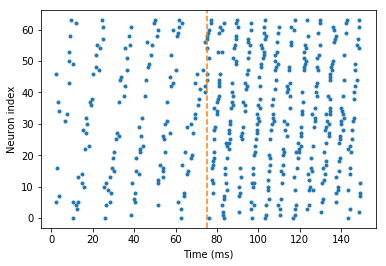

In [454]:
#figure(figsize=(10,4))
#subplot(121)
plot(G1e_sp.t/ms, G1e_sp.i,'.')
xlabel('Time (ms)')
ylabel('Neuron index')
#xlim([50,52])
axvline(x=75, LineStyle='--', color='C1')

Text(0,0.5,'Neuron index')

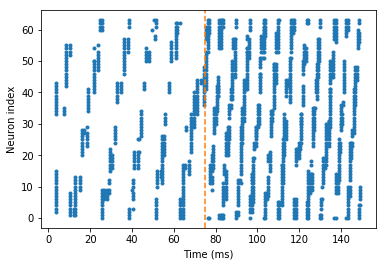

In [457]:
#subplot(122)
plot(G1i_sp.t/ms, G1i_sp.i,'.')
axvline(x=75,LineStyle='--',color='C1')
xlabel('Time (ms)')
ylabel('Neuron index')
#xlim([50,52])

In [391]:
len(G1e_sp) + len(G1i_sp)

1972

## Load Outputs and Plot

WARNING    /home/adamc/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
 [py.warnings]


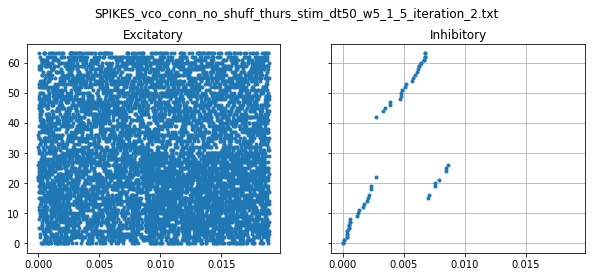

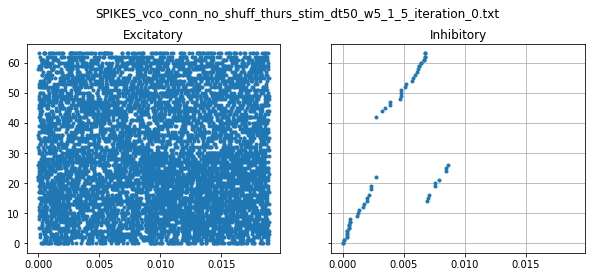

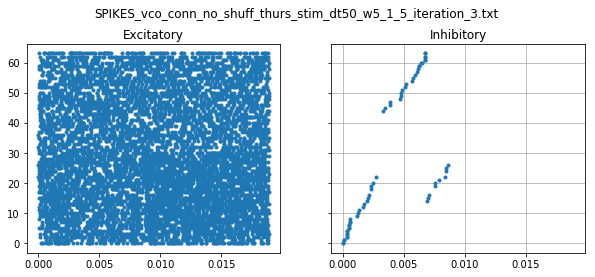

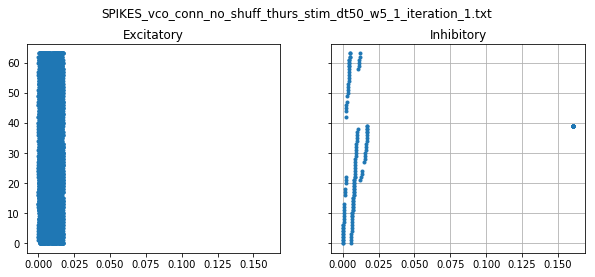

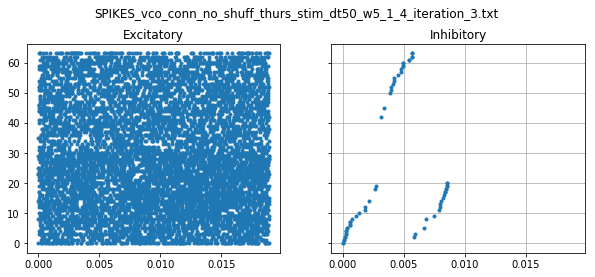

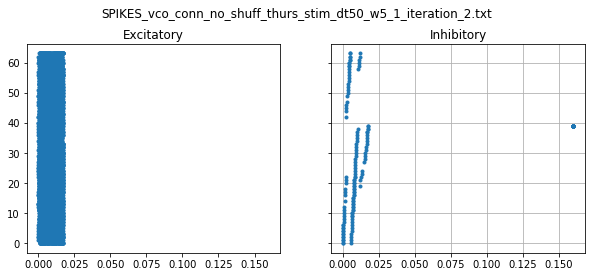

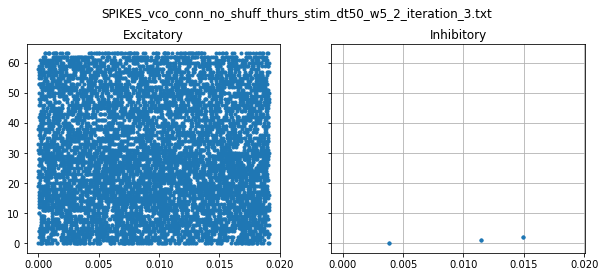

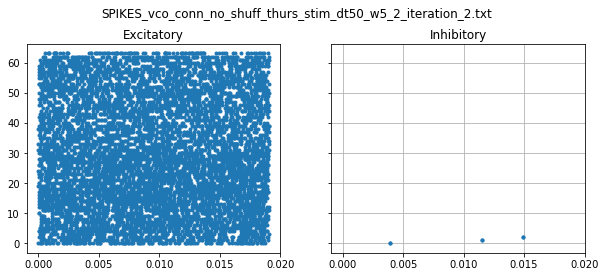

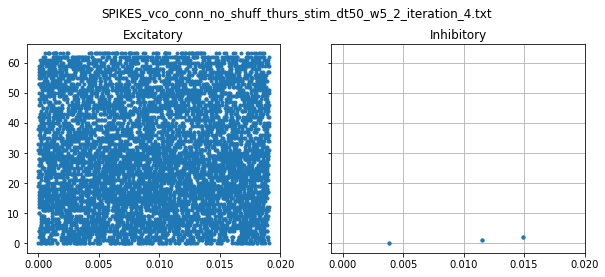

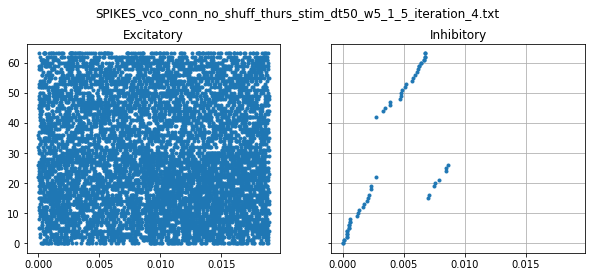

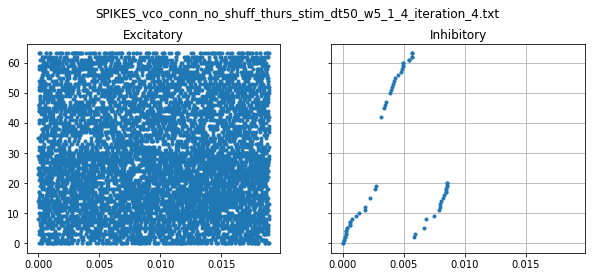

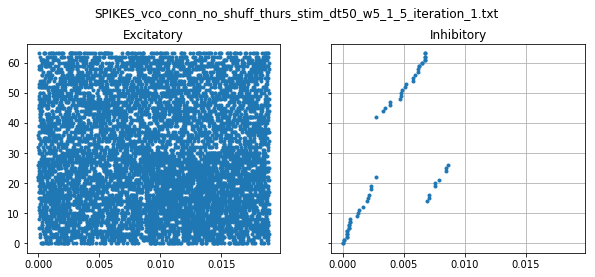

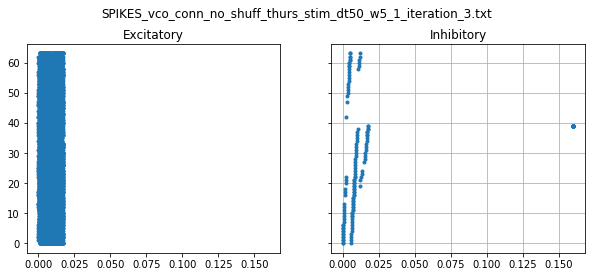

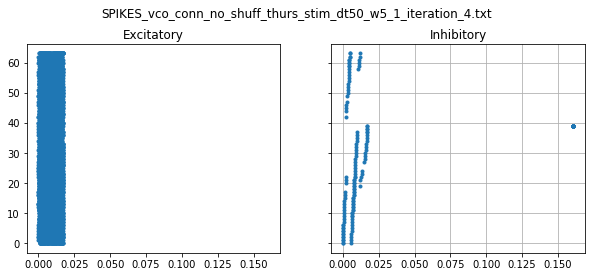

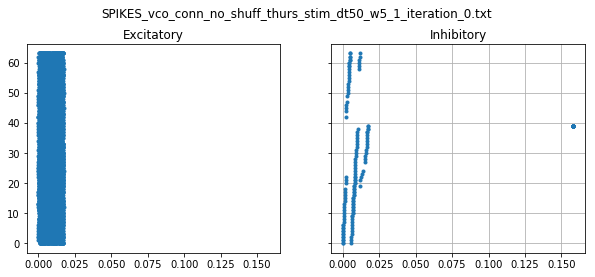

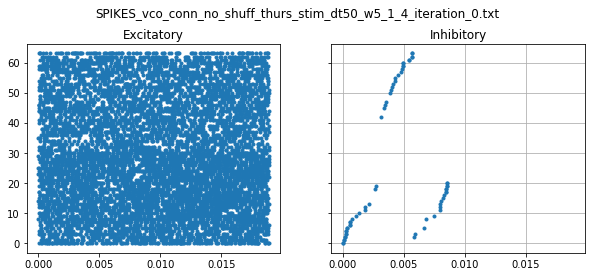

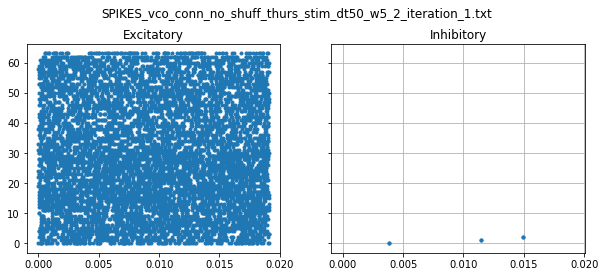

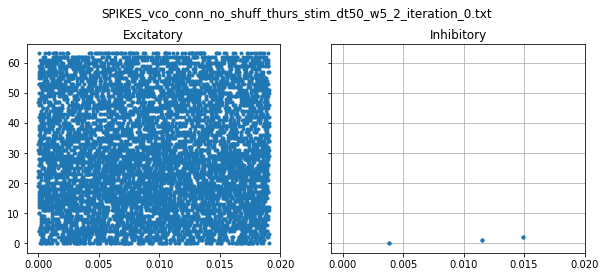

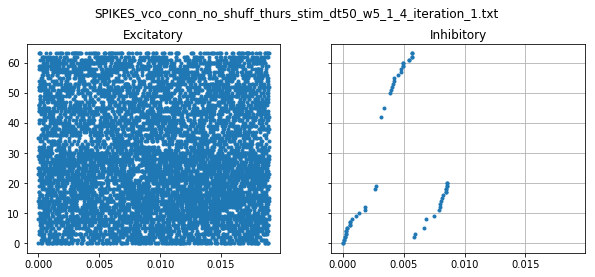

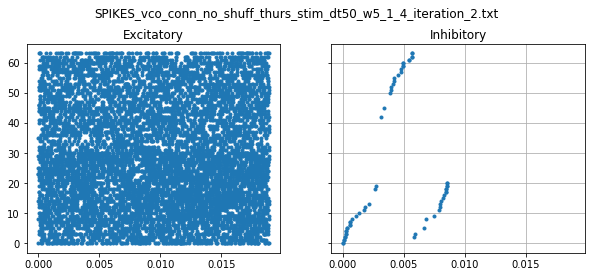

In [508]:
import os

numfiles = 0
for root, dirs, files in os.walk('/home/adamc/Documents/research/ifat-py/dt50_stim_spikes/'):
    numfiles = len(files)
    for file in files:
        full_file = os.path.join(root, file)
        
        exc_sp, exc_t, inh_sp, inh_t = read_ifat_spikes_2(full_file,10*us)
        if len(inh_t) < 5:
            continue
        figure(figsize=(10,4))
        fig, axs = subplots(1,2,figsize=(10,4),sharex=True,sharey=True)
        axs[0].plot(exc_t, exc_sp,'.')
        axs[1].plot(inh_t, inh_sp,'.')
        axs[0].set_title('Excitatory')
        axs[1].set_title('Inhibitory')
        #fig.suptitle(file)
        fig.subplots_adjust(top=0.85)
        fig.suptitle(file)
        #xlim([0,0.02])

        grid()
        #tight_layout()

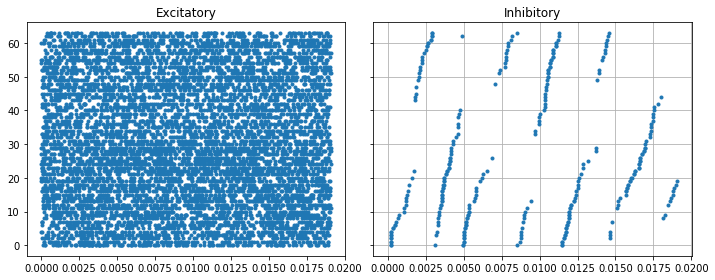

In [519]:
exc_sp, exc_t, inh_sp, inh_t = read_ifat_spikes_2('thurs_out/SPIKES_vco_conn_no_shuff_thurs_stim_dt10_w5_4_iteration_0.txt',10*us)

figure(figsize=(10,4))
fig, axs = subplots(1,2,figsize=(10,4),sharex=True,sharey=True)
axs[0].plot(exc_t, exc_sp,'.')
axs[1].plot(inh_t, inh_sp,'.')
axs[0].set_title('Excitatory')
axs[1].set_title('Inhibitory')

#xlim([0,0.018])

grid()
tight_layout()

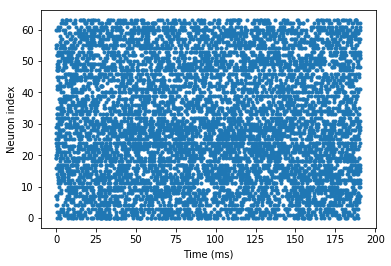

In [513]:
plot(exc_t*10000, exc_sp, '.')
xlabel('Time (ms)')
ylabel('Neuron index')
#xlim([50,52])
#axvline(x=75, LineStyle='--', color='C1')
exc_x = xlim()

(-9.534999999999998, 200.23499999999996)

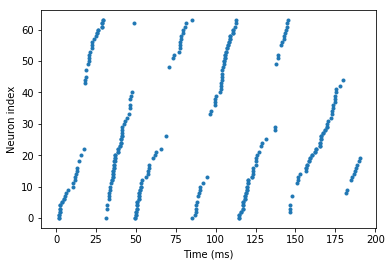

In [514]:
plot(inh_t*10000, inh_sp, '.')
xlabel('Time (ms)')
ylabel('Neuron index')
#xlim([50,52])
#axvline(x=75, LineStyle='--', color='C1')
xlim(exc_x)

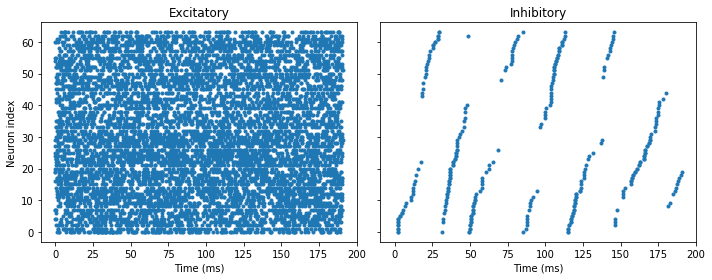

In [515]:
fig, axs = subplots(1,2,figsize=(10,4),sharex=True,sharey=True)
axs[0].plot(exc_t*10000, exc_sp,'.')
axs[0].set_xlabel('Time (ms)')
axs[0].set_ylabel('Neuron index')
axs[1].plot(inh_t*10000, inh_sp,'.')
axs[1].set_xlabel('Time (ms)')
axs[0].set_title('Excitatory')
axs[1].set_title('Inhibitory')

xlim(exc_x)
tight_layout()

In [520]:
len(exc_t)

7874

### List of good files
    -  thurs_out/SPIKES_vco_conn_no_shuff_thurs_stim_dt10_w5_4_*
    -  thurs_out/SPIKES_vco_conn_no_shuff_thurs_stim_dt50_w5_1_*
    -  

NOTE: `vbsf_500mv_w25.txt` seems to work kind of well. All excitatory synapses have Em=5 volts, poisson input spikes have W=125fF, Vt=1.8 volt, Vbsf=0.5

## Output connectivity and stim files

In [352]:
def write_poisson_stim(time, spikes, synapse, file):
    count = 0
    Em = int(synapse.Em[0]*3/(5*volt))
    Wm = int(synapse.W[0]/(5*fF))
    EXC = 0
    
    with open(file, 'w') as f:
        for i, t in enumerate(time):
            f.write('{}:'.format(round(t/us)))
            for j in range(shape(spikes)[0]):
                if spikes[j,i]:
                    # this is currently specific, we can generalize it
                    f.write('{} '.format(make_event(j, EXC, Wm, Em)))
                    count += 1
            if i<len(time)-1:
                f.write('\n')
    print('Number of Poisson spikes:',count)

In [392]:
group1 = {'weights': W1_e2i, 'Em': 3, 'stype': 0, 'ttype': 1}
group2 = {'weights': W1_i2e, 'Em': 0, 'stype': 1, 'ttype': 0}
group3 = {'weights': W1_i2i, 'Em': 0, 'stype': 1, 'ttype': 1}

write_exc_syn_old(group1,'vco_conn_OLD.txt')
write_inh_syn_old(group2, group3, 'vco_conn_OLD.txt', append=True)

Total number of Poisson spikes: 28853


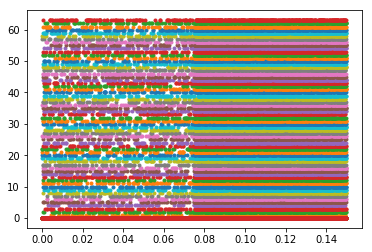

In [472]:
bayo_dt = 50*us
bayo_time = 150*ms

time_1, out_1 = poissonSpikeGen(rate=1*kHz, dt=bayo_dt, t=bayo_time/2, num_neur=M)
time_2, out_2 = poissonSpikeGen(rate=5*kHz, dt=bayo_dt, t=bayo_time/2, num_neur=M)
time_2 = time_2/second + bayo_time/(2*second)
time = concatenate((time_1,time_2))*second
out = concatenate((out_1, out_2),axis=1)

for idx in range(M):
    plot(time,out[idx]*idx,'.');

print('Total number of Poisson spikes: {}'.format(sum(out)))

times, indices = make_spgen(time, out)

In [ ]:
write_poisson_stim(time, out, P1_syn, 'thurs_stim_dt50_w5_1_5.txt')
# NB: All files of the form `thurs_stim_*.txt` have not been tested in simulation, but are meant to characterize various IFAT behaviors given different stimulation parameters.